# Captum을 사용하여 모델 해석하기

Captum으ㄹ 사용하면 데이터 특징(feature)이 모델의 예측 또는 뉴런 활성화에 미치는 영향을 이해할 수 있다. 모델의 동작 방식을 알 수 있다.

또한 Integrated Gradients와 Guided GradCam과 같은 feature attribution알고리즘을 적용할 수 있다.

In [2]:
import torchvision
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

In [4]:
model = torchvision.models.resnet18(pretrained=True).eval()

response = requests.get("https://image.freepik.com/free-photo/two-beautiful-puppies-cat-dog_58409-6024.jpg")

img = Image.open(BytesIO(response.content))

center_crop = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
])

normalize = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
  )
])

input_img = normalize(center_crop(img)).unsqueeze(0)

/Users/asanobm/miniconda3/envs/pytorch-study/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/asanobm/miniconda3/envs/pytorch-study/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 속성(attribution) 계산하기

모델의 top-3 예측 중에는 개와 고양이에 해당하는 클래스 208과 283이 있다.

Captum의 `Oclusion`알고리즘을 사용하여 각 예측을 입력의 해당 부분에 표시한다.

In [9]:
from captum.attr import Occlusion

occlusion = Occlusion(model)

strides = (3, 9, 9) # smaller = more fine-grained attribution
target = 208 # class index for "Labrador retriever"
sliding_window_shapes=(3,45, 45) # choose size of the occlusion window
baselines = 0 # default value

attribution_dog = occlusion.attribute(
  input_img,
  strides=strides,
  target=target,
  sliding_window_shapes=sliding_window_shapes,
  baselines=baselines
)

target=283
attribution_cat = occlusion.attribute(
  input_img,
  strides=strides,
  target=target,
  sliding_window_shapes=sliding_window_shapes,
  baselines=baselines
)

Captum은 `Occlusion`외 `Integrated Gradients`, `Decovolution`, `Guided GradCam`, `DeepLift`, `GradientShape`과 같은 많은 알고리즘을 제공한다. 이러한 모든 알고리즘은 초기화할 때 모델을 호출 가능한 `forward_func`으로 기대하며 속성(attribution)결과를 통합해서 반환하는 `attribute(....)`메서드를 가지는 `Attribution`의 서브 클래스이다.

## 결과 시각화

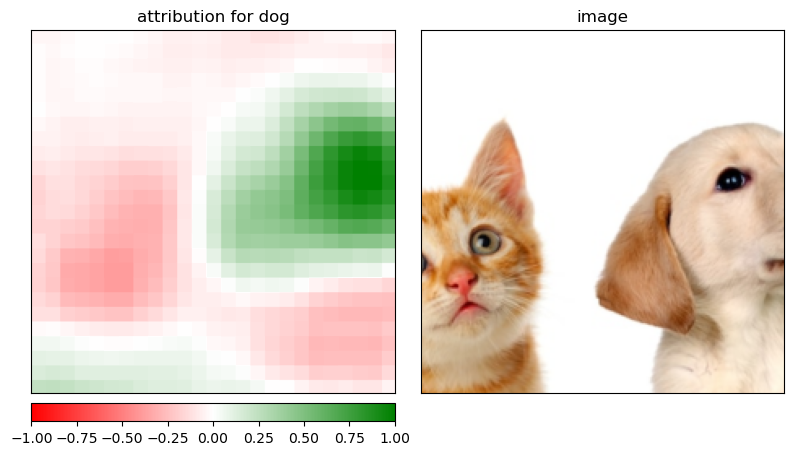

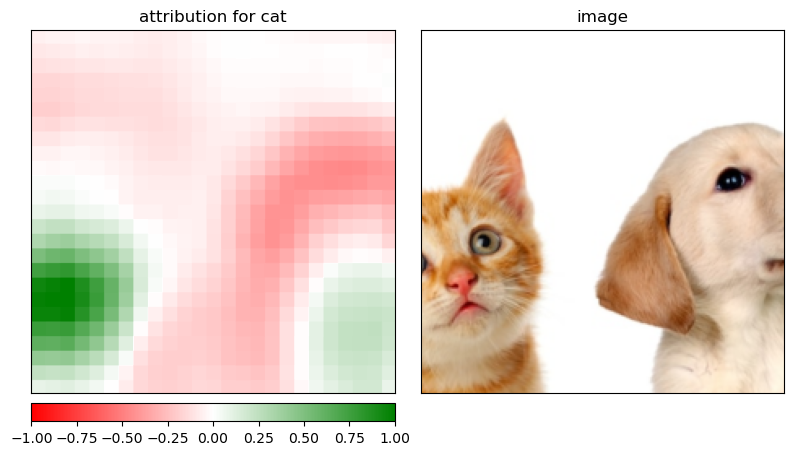

In [10]:
import numpy as np
from captum.attr import visualization as viz

attribution_dog = np.transpose(attribution_dog.squeeze().cpu().detach().numpy(), (1,2,0))

vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"]
# positive 속성은 해당 영역의 존재가 예측 점수를 증가시킨다는 것을 의미합니다.
# negative 속성은 해당 영역의 존재가 예측 점수를 낮추는 오답 영역을 의미합니다.
# all은 모든 픽셀을 포함합니다.

_ = viz.visualize_image_attr_multiple(attribution_dog,
                                  np.array(center_crop(img)),
                                  vis_types,
                                  vis_signs,
                                  ["attribution for dog", "image"],
                                  show_colorbar = True
                                  )

attribution_cat = np.transpose(attribution_cat.squeeze().cpu().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr_multiple(attribution_cat,
                                      np.array(center_crop(img)),
                                      ["heat_map", "original_image"],
                                      ["all", "all"], # positive/negative 속성 또는 all
                                      ["attribution for cat", "image"],
                                      show_colorbar = True
                                     )